# 프로젝트: 뉴스기사 요약해보기

# [ 목차 ]
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기 (추상적 요약)
- Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- Step 5. Summa을 이용해서 추출적 요약해보기

In [54]:
# 주요 라이브러리 버전 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## Step 1. 데이터 수집하기
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [55]:
# 뉴스 기사 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [56]:
# 데이터 확인
data.sample(10)

,headlines,text
42579,Helmet-shaped brain scanner allows patients to...,UK-based researchers have claimed to invent th...
55624,"Rohit 2nd Indian after Kohli to slam 1,500 run...",Indian opener Rohit Sharma has become the seco...
76459,I take 100 catches in every practice session: ...,Ajinkya Rahane has revealed that he takes 100 ...
50598,Women BSF bikers participate in R-Day parade f...,An all-woman bikers contingent of the Border S...
77046,Virender Sehwag meets members of Indian women'...,Virender Sehwag took to Twitter to share a pic...
7689,No reason to replace Powar: Kaur to BCCI amid ...,India Women T20I captain Harmanpreet Kaur has ...
15058,"Infected polio vaccines given to kids in UP, M...",Health Ministry officials confirmed that some ...
15529,Dhoni completes 800 dismissals in internationa...,Indian wicketkeeper MS Dhoni completed 800 dis...
86156,SBI launches record share sale to raise up to ...,India's largest lender SBI launched the countr...
71428,Kalanick praises Khosrowshahi on his first day...,Ousted Uber CEO Travis Kalanick appreciated Da...


In [57]:
print("전체 샘플 수:", len(data))
print(data.head())

전체 샘플 수: 98401
                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  


## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 데이터 정리하기

In [58]:
# 필요한 라이브러리 불러오기
import nltk
nltk.download('stopwords') # NLTK 불용어 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**중복 및 Null 값 제거**

In [59]:
# 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [60]:
# 중복 제거
data.drop_duplicates(subset=['text'], inplace=True)

In [61]:
# Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [62]:
print("중복값 제거 후 샘플 수:", len(data))

중복값 제거 후 샘플 수: 98360


**텍스트 정규화 및 불용어 제거**

In [63]:
# 축약어 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [64]:
# 텍스트 정규화 및 불용어 제거
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 소문자 변환
    sentence = BeautifulSoup(sentence, "lxml").text  # HTML 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 축약어 변환
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 숫자 및 특수 문자 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # 연속된 'm' 정규화

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

In [65]:
# text 데이터 전처리 (불용어 제거 O)
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 결과 확인
print("Text 전처리 후:", clean_text[:5])

Text 전처리 후: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure cr

In [66]:
# headlines 데이터 전처리 (불용어 제거 X)
clean_headlines = []

for headlines in data['headlines']:
    clean_headlines.append(preprocess_sentence(headlines, remove_stopwords=False))

# 결과 확인
print("Headlines 전처리 후:", clean_headlines[:5])

Headlines 전처리 후: ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [67]:
# 전처리 전, 후 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어 제거 X

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


**데이터프레임 갱신 및 최종 Null 값 제거**

In [68]:
# 전처리된 데이터 저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [69]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

**샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


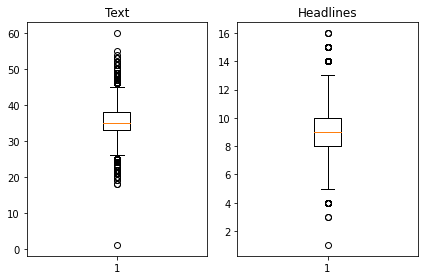

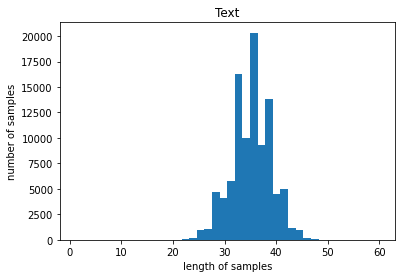

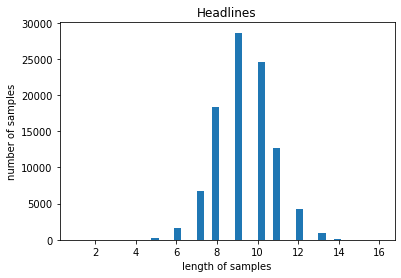

In [70]:
# 샘플 길이 분석
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
text_max_len = 50
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
    return sum(1 for s in nested_list if len(s.split()) <= max_len) / len(nested_list)

print('Text 길이 50 이하 비율:', below_threshold_len(text_max_len, data['text']))
print('Headlines 길이 12 이하 비율:', below_threshold_len(headlines_max_len, data['headlines']))

Text 길이 50 이하 비율: 0.9998576657177715
Headlines 길이 12 이하 비율: 0.9880337535583571


In [72]:
# text_max_len과 headlines_max_len보다 긴 샘플 제거
data = data[
    data['text'].apply(lambda x: len(x.split()) <= text_max_len) & 
    data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 전체 샘플 수 출력
print('전체 샘플수 :', len(data))

전체 샘플수 : 97169


In [73]:
# 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [74]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

**훈련 데이터와 테스트 데이터 분리**

In [75]:
# 데이터 섞기
indices = np.arange(encoder_input.shape[0]) # [0, 1, 2, 3, ..., N-1] (문장 개수만큼의 인덱스 생성)
np.random.shuffle(indices) # 인덱스를 랜덤하게 섞기

# 데이터를 무작위로 섞되, 각 데이터셋(입력, 출력, 레이블)이 같은 방식으로 섞이도록 유지
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [76]:
# 데이터 분할 (훈련 8:테스트 2)
n_of_val = int(len(encoder_input) * 0.2)
encoder_input_train, encoder_input_test = encoder_input[:-n_of_val], encoder_input[-n_of_val:]
decoder_input_train, decoder_input_test = decoder_input[:-n_of_val], decoder_input[-n_of_val:]
decoder_target_train, decoder_target_test = decoder_target[:-n_of_val], decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


### 정수 인코딩

In [77]:
# 단어 집합 만들기 (각 단어에 고유한 정수 맵핑)
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [78]:
# 등장 빈도수가 7회 미만인 단어들의 비중 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69460
등장 빈도가 6번 이하인 희귀 단어의 수: 47383
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 22077
단어 집합에서 희귀 단어의 비율: 68.21623956233803
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.513527178560515


In [79]:
# 단어 집합의 크기 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [80]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[101, 2033, 199, 97, 68, 1211, 303, 5547, 18341, 1416, 12, 126, 2206, 8233, 1, 2061, 84, 291, 2070, 1556, 1024, 19343, 1097, 1696, 198, 1629, 1455, 4436, 10916, 2902, 16668], [179, 2, 94, 1498, 1674, 244, 39, 3629, 1751, 1137, 685, 12473, 3324, 2013, 245, 589, 179, 4969, 4786, 81, 177, 1498, 1674, 496, 1247, 81, 15303, 6506, 32, 846], [132, 191, 58, 70, 51, 871, 170, 206, 2329, 598, 149, 143, 24, 293, 1371, 871, 1970, 146, 24, 493, 1239, 256, 567, 5382, 5048, 5548, 1970, 451, 427, 7, 149, 191, 70, 1898, 2979]]


In [81]:
# headlines 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [82]:
# 등장 빈도수가 6회 미만인 단어들의 비중 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29946
등장 빈도가 5번 이하인 희귀 단어의 수: 19601
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 10345
단어 집합에서 희귀 단어의 비율: 65.45448473919721
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.725914288295704


In [83]:
# 단어 집합의 크기 제한
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 224, 166, 549, 6143, 4, 146, 10, 2258, 107, 333], [1, 97, 8, 418, 4971, 1796, 5, 250, 4, 77, 2662], [1, 296, 3, 749, 159, 87, 545, 807, 198, 397, 390], [1, 8763, 3763, 25, 16, 869, 109, 3009, 3089, 4, 919], [1, 2901, 730, 53, 1520, 611, 883, 5, 685, 686]]
target
decoder  [[224, 166, 549, 6143, 4, 146, 10, 2258, 107, 333, 2], [97, 8, 418, 4971, 1796, 5, 250, 4, 77, 2662, 2], [296, 3, 749, 159, 87, 545, 807, 198, 397, 390, 2], [8763, 3763, 25, 16, 869, 109, 3009, 3089, 4, 919, 2], [2901, 730, 53, 1520, 611, 883, 5, 685, 686, 2]]


In [84]:
# 요약문에서 길이가 0이 된 샘플 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19432
테스트 레이블의 개수 : 19432


In [85]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계하기

In [86]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [87]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [88]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 어텐션 메커니즘

In [89]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [90]:
# 설계한 모델로 훈련 진행
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 40s 113ms/step - loss: 5.6222 - val_loss: 5.1862
Epoch 2/50
304/304 [==============================] - 32s 106ms/step - loss: 5.0488 - val_loss: 4.8301
Epoch 3/50
304/304 [==============================] - 32s 107ms/step - loss: 4.7075 - val_loss: 4.5516
Epoch 4/50
304/304 [==============================] - 33s 108ms/step - loss: 4.4462 - val_loss: 4.3681
Epoch 5/50
304/304 [==============================] - 32s 107ms/step - loss: 4.2410 - val_loss: 4.2323
Epoch 6/50
304/304 [==============================] - 33s 107ms/step - loss: 4.0682 - val_loss: 4.1100
Epoch 7/50
304/304 [==============================] - 33s 107ms/step - loss: 3.9185 - val_loss: 4.0287
Epoch 8/50
304/304 [==============================] - 33s 107ms/step - loss: 3.7866 - val_loss: 3.9553
Epoch 9/50
304/304 [==============================] - 33s 107ms/step - loss: 3.6696 - val_loss: 3.8959
Epoch 10/50
304/304 [==============================] - 33s 107ms/step - l

In [91]:
# 메인 모델 저장
MODEL_PATH = "/aiffel/aiffel/fastAPI/news_model.h5"
model.save(MODEL_PATH)
print(f"✅ 메인 모델이 {MODEL_PATH} 경로에 저장되었습니다.")

# 인퍼런스 모델도 따로 저장
ENCODER_MODEL_PATH = "/aiffel/aiffel/fastAPI/encoder_model.h5"
DECODER_MODEL_PATH = "/aiffel/aiffel/fastAPI/decoder_model.h5"

encoder_model.save(ENCODER_MODEL_PATH)
decoder_model.save(DECODER_MODEL_PATH)

print(f"✅ 인퍼런스 모델이 {ENCODER_MODEL_PATH}, {DECODER_MODEL_PATH} 경로에 저장되었습니다.")

✅ 메인 모델이 /aiffel/aiffel/fastAPI/news_model.h5 경로에 저장되었습니다.
✅ 인퍼런스 모델이 /aiffel/aiffel/fastAPI/encoder_model.h5, /aiffel/aiffel/fastAPI/decoder_model.h5 경로에 저장되었습니다.


In [92]:
import pickle

# src_tokenizer 저장
with open("/aiffel/aiffel/fastAPI/src_tokenizer.pkl", "wb") as f:
    pickle.dump(src_tokenizer, f)

# tar_tokenizer 저장
with open("/aiffel/aiffel/fastAPI/tar_tokenizer.pkl", "wb") as f:
    pickle.dump(tar_tokenizer, f)

print("✅ 토크나이저가 정상적으로 저장되었습니다.")

✅ 토크나이저가 정상적으로 저장되었습니다.


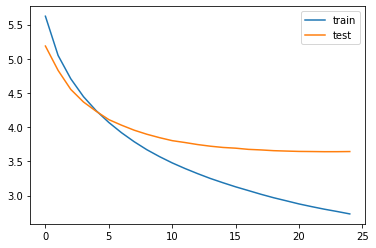

In [93]:
# 훈련과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [94]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [95]:
#어텐션 메커니즘을 사용하는 입력층 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [96]:
#어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [97]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [98]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()  # 마지막 공백 제거

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [99]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pg medical student accused three medical college professors sexual harassment allegedly committed suicide hanging andhra pradesh chittoor district year old woman recently failed post graduate exams claimed deliberately failed complained professors suicide triggered protests students college 
실제 요약 : pg student who accused profs of sexual harassment ends life
예측 요약 :  iit student alleges self from college commits suicide


원문 : days rising kashmir editor shujaat bukhari shot dead assailants union minister jitendra singh said hesitation saying pakistan sponsored agencies calling bukhari activist tried follow middle path claimed pakistan strategy get activists try walk middle path scene 
실제 요약 : rising kashmir editor was killed by pakistan minister
예측 요약 :  hizbul chief claims he was shot dead by terrorists


원문 : death toll las vegas mass shooting risen people injured police said adding suspected shooter police said believe shooters shooter allegedly used automatic weapon attack cit

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [160]:
# 패키지 설치 및 가져오기
import pandas as pd
import urllib.request
from summa.summarizer import summarize

In [161]:
# 뉴스 기사 데이터 다운로드 및 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv",
                           filename="news_summary_more.csv")

data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [162]:
# 랜덤 샘플 선택 (예제: 3번째 기사)
sample_text = data['text'][2]  # 2번째 행의 뉴스 기사 원문

print("\n원문:")
print(sample_text)  # 원문 출력


원문:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [163]:
# 비율 기반 요약 (뉴스 기사 원문의 50% 요약)
print("\n비율 기반 요약 (50%)")
print(summarize(sample_text, ratio=0.5))


비율 기반 요약 (50%)
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [164]:
# 단어 수 기반 요약 (단어 30개만 유지)
print("\n단어 수 기반 요약 (30단어)")
print(summarize(sample_text, words=30))


단어 수 기반 요약 (30단어)
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series.
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [165]:
# 요약 결과를 리스트 형태로 출력
print("\n리스트 형태 요약")
print(summarize(sample_text, ratio=0.5, split=True))


리스트 형태 요약
['The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.']


In [166]:
# 원문, 추출적 요약 비교
for i in range(70, 80):  # 70번부터 79번까지 총 10개의 샘플 요약
    original_text = data['text'][i]  # 원문 가져오기

    # 단어 수 기반 요약 (20단어 유지)
    extractive_summary = summarize(original_text, words=20)

    print(f"\n\n===== 샘플 {i} =====")
    print(f"원문:\n{original_text}\n")
    print(f"추출적 요약(20단어 유지):\n{extractive_summary}\n")



===== 샘플 70 =====
원문:
Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, in hopes of increasing sales, are reportedly occurring for second time in 12 years.

추출적 요약(20단어 유지):
"WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.



===== 샘플 71 =====
원문:
Scientists in Australia's Flinders University are testing a wetsuit prototype that could protect its wearer after a shark attack. The suit, made of synthetic material similar to the material used in bulletproof vests, could help reduce blood loss after a shark attack. "The majority of fatalities from shark bites is due to blood loss...shock from blood loss," a scientist said.

추출적 요약(20단어 유지):
"The majority of fatalities from shark bites is due t

## 추상적 요약 vs 추출적 요약 비교
### 1. ROUGE의 주요 지표:
1. ROUGE-N:

- ROUGE-1: 1-그램(단어)의 정확도, 재현율, F1 점수를 계산합니다.
- ROUGE-2: 2-그램(연속된 두 단어)의 정확도, 재현율, F1 점수를 계산합니다.
- 예를 들어, ROUGE-1은 한 단어씩 비교하고, ROUGE-2는 두 단어씩 비교하여 요약이 얼마나 잘 일치하는지 평가합니다.

2. ROUGE-L:

- LCS (Longest Common Subsequence)를 기준으로 최장 공통 부분 수열을 계산합니다.
- 요약이 원본 문서에서 문장 구조를 얼마나 잘 유지하는지를 측정하는 지표입니다.
- 요약된 문장에서 최대 일치 부분을 찾고, 이를 바탕으로 정확도, 재현율, F1 점수를 계산합니다.


### 2. ROUGE의 평가 지표:
- Precision (정확도): 요약된 텍스트에 포함된 단어가 원본 텍스트에 얼마나 일치하는지를 측정합니다.
- Recall (재현율): 원본 텍스트에서 나온 중요한 단어가 요약된 텍스트에 얼마나 포함되었는지 측정합니다.
- F1 Score: Precision과 Recall의 조화 평균을 구한 값으로, 두 지표의 균형을 평가합니다.

In [167]:
!pip install rouge-score

In [168]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from summa.summarizer import summarize

# 경고 메시지 무시하기
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# 추상적 요약 결과 (decode_sequence로 생성된 요약)
abstractive_summary = decode_sequence(encoder_input_test[0].reshape(1, text_max_len))

# 추출적 요약 결과 (Summa 라이브러리 사용)
sample_text = data['text'][2]  # 'text' 컬럼 대신 실제 데이터 컬럼을 확인 후 사용
extractive_summary = summarize(sample_text, words=20)

# 원문, 추상적 요약, 추출적 요약 출력
print(f"원문:\n{sample_text}")
print(f"\n추상적 요약:\n{abstractive_summary}")
print(f"\n추출적 요약:\n{extractive_summary}")

# ROUGE 점수 계산
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
abstractive_scores = scorer.score(sample_text, abstractive_summary)
extractive_scores = scorer.score(sample_text, extractive_summary)

# ROUGE 점수 출력
print("\n추상적 요약 ROUGE 점수:")
print(abstractive_scores)

print("\n추출적 요약 ROUGE 점수:")
print(extractive_scores)

# ROUGE 점수를 pandas DataFrame으로 정리
data = {
    "ROUGE-N": ["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "추상적 요약 Precision": [
        abstractive_scores['rouge1'].precision,
        abstractive_scores['rouge2'].precision,
        abstractive_scores['rougeL'].precision
    ],
    "추상적 요약 Recall": [
        abstractive_scores['rouge1'].recall,
        abstractive_scores['rouge2'].recall,
        abstractive_scores['rougeL'].recall
    ],
    "추상적 요약 F1 Score": [
        abstractive_scores['rouge1'].fmeasure,
        abstractive_scores['rouge2'].fmeasure,
        abstractive_scores['rougeL'].fmeasure
    ],
    "추출적 요약 Precision": [
        extractive_scores['rouge1'].precision,
        extractive_scores['rouge2'].precision,
        extractive_scores['rougeL'].precision
    ],
    "추출적 요약 Recall": [
        extractive_scores['rouge1'].recall,
        extractive_scores['rouge2'].recall,
        extractive_scores['rougeL'].recall
    ],
    "추출적 요약 F1 Score": [
        extractive_scores['rouge1'].fmeasure,
        extractive_scores['rouge2'].fmeasure,
        extractive_scores['rougeL'].fmeasure
    ]
}

원문:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

추상적 요약:
 karnataka cm to get kumaraswamy office for office

추출적 요약:
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

추상적 요약 ROUGE 점수:
{'rouge1': Score(precision=0.375, recall=0.04838709677419355, fmeasure=0.0857142857142857), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.375, recall=0.04838709677419355, fmeasure=0.0857142857142857)}

추출적 요약 ROUGE 점수:
{'rouge1': Score(precision=1.0, recall=0.27419354838709675, fmeasure=0.430379746835443), 'rouge2': Score(precision=1.0, recall=0.26229508196721313, fmeasure=0.41558441558441556), 'rougeL':


ROUGE 평가 결과 (DataFrame 형태):
   ROUGE-N  추상적 요약 Precision  추상적 요약 Recall  추상적 요약 F1 Score  \
0  ROUGE-1             0.375       0.048387         0.085714   
1  ROUGE-2             0.000       0.000000         0.000000   
2  ROUGE-L             0.375       0.048387         0.085714   

   추출적 요약 Precision  추출적 요약 Recall  추출적 요약 F1 Score  
0               1.0       0.274194         0.430380  
1               1.0       0.262295         0.415584  
2               1.0       0.274194         0.430380  


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52628 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_

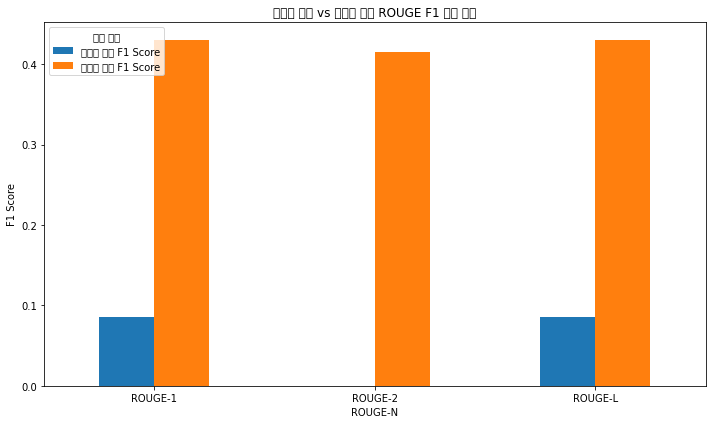

In [169]:
# DataFrame으로 결과 출력
df = pd.DataFrame(data)
print("\nROUGE 평가 결과 (DataFrame 형태):")
print(df)

# 시각화: ROUGE 점수 비교
fig, ax = plt.subplots(figsize=(10, 6))
df.set_index('ROUGE-N')[['추상적 요약 F1 Score', '추출적 요약 F1 Score']].plot(kind='bar', ax=ax)

ax.set_title("추상적 요약 vs 추출적 요약 ROUGE F1 점수 비교")
ax.set_xlabel("ROUGE-N")
ax.set_ylabel("F1 Score")
ax.legend(title="요약 방법", loc="upper left")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 비교 결과 해석

**1. 추상적 요약:**

1) ROUGE-1:
- Precision: 0.375, Recall: 0.0484, F1 Score: 0.0857
- 추상적 요약은 원문과 일치하는 단어를 약간만 포함하고 있으며, F1 점수가 매우 낮은 값을 보입니다.
- 이는 추상적 요약이 **원문에서 중요한 정보를 잘 반영하지 못하였음**을 의미합니다.

2) ROUGE-2:
- Precision: 0.0, Recall: 0.0, F1 Score: 0.0
- 추상적 요약은 2-그램(두 단어씩) 기준으로는 원문과 전혀 일치하지 않으며, 0점을 기록합니다.
- 즉, **문맥적으로 중요한 단어들을 잘 반영하지 않았다**는 의미입니다.

3) ROUGE-L:
- Precision: 0.375, Recall: 0.0484, F1 Score: 0.0857
- ROUGE-L에서는 최장 공통 부분 수열을 기준으로 **원문과 일치하는 부분이 부족하다**는 결과가 나왔습니다.
---

**2. 추출적 요약:**

1) ROUGE-1:
- Precision: 1.0, Recall: 0.274, F1 Score: 0.4304
- 추출적 요약은 원문에서 단어를 그대로 추출한 경우로, Precision이 1.0이라서 원문에서 나온 단어들을 모두 포함했음을 알 수 있습니다. 
- 하지만 Recall은 0.274로 **추출된 단어 중 일부만 원문에 포함되었음**을 의미합니다.

2) ROUGE-2:
- Precision: 1.0, Recall: 0.262, F1 Score: 0.4156
- 2-그램 기준에서도 추출적 요약이 원문에서 중요한 2-그램을 잘 추출했음을 보여줍니다.
- F1 점수가 높게 나온 것을 보면, **원문에 중요한 정보를 잘 유지했음**을 알 수 있습니다.

3) ROUGE-L:
- Precision: 1.0, Recall: 0.274, F1 Score: 0.4304
- ROUGE-L에서 추출적 요약은 최장 공통 부분 수열 기준으로도 좋은 성과를 보였습니다.
- **원문에서 중요한 구문을 잘 유지했음**을 나타냅니다.
---
**[ 결론 ]**

그래프에서 **주황색 바 (추출적 요약)**가 **파란색 바 (추상적 요약)**보다 상대적으로 더 긴 것을 보면, **추출적 요약이 추상적 요약보다 높은 성능을 보인다**는 것을 알 수 있습니다.
- 추상적 요약은 창의성이 강하지만, 원문에 포함된 중요한 정보를 잘 반영하지 못하는 경우가 많아 ROUGE 점수가 낮습니다.
- 추출적 요약은 정확도와 재현율에서 높은 점수를 얻어, 원문에 포함된 중요한 내용을 잘 요약하는 방식입니다.